# Загрузка зависимостей

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import torch
from IPython.display import clear_output
import seaborn as sns
import multiprocessing
import zipfile
import sys
import os
import string
import re
from tqdm.notebook import tqdm

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [44]:
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [103]:
!pip install pymorphy2
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://ai-data.obs.ru-moscow-1.hc.sbercloud.ru/%D1%8E%D1%80%D0%B8%D0%B4%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D0%BD%D0%B8%D0%BA.zip \
-O data.zip
!unzip data.zip
!rm data.zip

--2022-08-27 03:47:24--  https://ai-data.obs.ru-moscow-1.hc.sbercloud.ru/%D1%8E%D1%80%D0%B8%D0%B4%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D0%BD%D0%B8%D0%BA.zip
Resolving ai-data.obs.ru-moscow-1.hc.sbercloud.ru (ai-data.obs.ru-moscow-1.hc.sbercloud.ru)... 46.243.206.34, 46.243.206.35
Connecting to ai-data.obs.ru-moscow-1.hc.sbercloud.ru (ai-data.obs.ru-moscow-1.hc.sbercloud.ru)|46.243.206.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6373384 (6.1M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   6.08M  4.14MB/s    in 1.5s    

2022-08-27 03:47:26 (4.14 MB/s) - ‘data.zip’ saved [6373384/6373384]

Archive:  data.zip
replace Документы/208_ot_18_fevralya_2022.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [104]:
torch.cuda.is_available()

False

# Работа с данными

## Подготовка данных

Сначала просто подготовим все наши данные в excel формате

In [ ]:
!pip install docx2txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3980 sha256=7a4d2cef1fa2e5eff5a1452db10282c2f53e0c6f4f55b3fec663b763245db16d
  Stored in directory: /root/.cache/pip/wheels/b7/20/b2/473e3aea9a0c0d3e7b2f7bd81d06d0794fec12752733d1f3a8
Successfully built docx2txt


In [ ]:
import docx2txt

def docx2csv(root):
  df = pd.DataFrame(columns=['filename', 'text', 'label'])
  for filename in os.listdir(root):
    try: document = docx2txt.process(os.path.join(root, filename)).split('{')
    except IsADirectoryError: continue
    for row in document[1::2]:
      row_data = row.split('}')
      npa_label = row_data[0]
      try: npa_text = row_data[1] # там всего пару таких строчек, чтобы не кидало ошибку на не юникод символах
      except: continue
      df.loc[len(df.index)] = [filename, npa_text, npa_label]
  df.to_csv('data.csv', index=False)
docx2csv('Документы')

## Общая информация о данных

In [3]:
data = pd.read_csv('data.csv')
data.head()

,filename,text,label
0,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,"Настоящие Правила устанавливают цели, условия ...",2.0
1,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,"Понятия, используемые в настоящих Правилах, о...",1.0
2,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,"""администратор"" - юридическое лицо любой орга...",1.0
3,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,наличие официального сайта в информационно-те...,1.0
4,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,опыт участия не менее 2 лет в государственных...,1.0


In [4]:
data.shape

(18624, 3)

In [5]:
data.sample(20)

,filename,text,label
18544,Postanovlenie_Pravitelstva_RF_ot28_12_2019_N_1...,"несоответствие организации требованиям, указ...",21.0
5537,Постановление Правительства РФ от 08.10.2020 N...,Отбор осуществляется на основании следующих кр...,6.0
3954,Postanovlenie_Pravitelstva_ot_15_09_2020_1439....,Гранты предоставляются в пределах лимитов бюдж...,4.0
17531,Постановление Правительства РФ от 06.02.2021 N...,проведение комплекса аналитических и (или) мон...,2.0
11360,835_ot_9_maya_2022.docx,Министерство строительства и жилищно-коммунал...,22.0
6395,Postanovlenie_Pravitelstva_Rossiyskoy_Federats...,в случае заключения кредитного договора (согл...,6.0
4512,Postanovlenie_Pravitelstva_RF_ot_17_10_2018_N_...,количество приобретенного аварийно-спасательно...,27.0
477,664_ot_14_04_2022.docx,"""единый портал"" - портал предоставления мер ф...",1.0
7852,Postanovlenie_Pravitelstva_RF_ot_03_05_2019_N_...,Отчеты формируются и представляются посредств...,36.0
5959,Postanovlenie_Pravitelstva_ot_26_04_2021_N_646...,"Отчетность, указанная в подпункте ""е"" пункта 3...",37.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18624 entries, 0 to 18623
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  18624 non-null  object 
 1   text      18613 non-null  object 
 2   label     18623 non-null  float64
dtypes: float64(1), object(2)
memory usage: 436.6+ KB


In [7]:
data.describe()

,label
count,18623.000000
mean,20.003866
std,10.825362
min,1.000000
25%,11.000000
50%,20.000000
75%,27.000000
max,39.000000


In [8]:
data = data.dropna()

In [9]:
data_original = data.copy()

## Анализ label

Посмотрим на распределение классов

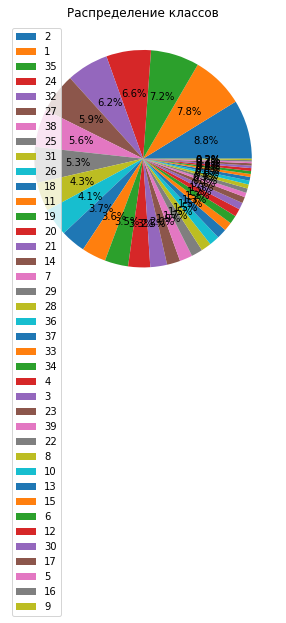

In [10]:
plt.figure(figsize=(5, 5))
plt.pie(data.label.value_counts(), autopct='%1.1f%%')
plt.legend([int(_) for _ in data.label.unique()])
plt.title('Распределение классов')
plt.show()

Видим, что классы не сбалансированы

## Анализ текста

### Токенизация nltk

In [12]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

def tokenize_text(text, min_word_length=1):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = BeautifulSoup(text, 'lxml').get_text() # удаляем html
    text = tokenizer.tokenize(text)
    return [token for token in text if len(token) > min_word_length]

In [14]:
def delete_stopwords(tokens):
  return ' '.join(list(filter(lambda token: token not in STOPWORDS, tokens)))

In [15]:
import pymorphy2

lemmatizer  = pymorphy2.MorphAnalyzer() # try: stemming
def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

In [16]:
def clean_data(text):
  tokens = tokenize_text(text)
  tokens = lemmatizing(tokens)
  tokens = delete_stopwords(tokens)
  return tokens

In [17]:
tqdm.pandas()
data.text = data.text.progress_apply(clean_data) # непосредственно сама токенизация

  0%|          | 0/18612 [00:00<?, ?it/s]

In [18]:
def delete_empty(df):
  empty = df.loc[df.text == '']
  print('Количество пустых комментариев после токенизации: {}'.format(len(empty)))
  df = df.drop(empty.index)
  return df

In [19]:
def delete_duplicates(df):
  duplicates = df.duplicated(subset=['text'])
  print('Количество дублирующих комментариев после токенизации: {}'.format(duplicates.sum()))
  df = df.drop_duplicates(ignore_index=True)
  return df

In [20]:
data = delete_empty(data)
data = delete_duplicates(data)

Количество пустых комментариев после токенизации: 466
Количество дублирующих комментариев после токенизации: 3829


### Токенизация spacy

In [ ]:
import spacy

In [ ]:
!spacy download ru_core_news_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 513.4 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


In [ ]:
nlp = spacy.load('ru_core_news_lg')

class TextPreprocessor():
  def __init__(self, nlp=nlp):
    self.nlp = nlp

  def transform(self, X: str) -> str:
    return self._preprocess_text(X)

  def _preprocess_text(self, text):
    doc = self.nlp(text)
    doc_no_punct = self._remove_punct(doc)
    doc_no_stopwords = self._remove_stopwords(doc_no_punct)
    doc_no_shortwords = self._remove_shortwords(doc_no_stopwords)
    return self._lemmatize(doc_no_shortwords)

  def _remove_punct(self, doc):
    return (t for t in doc if t.text not in string.punctuation)

  def _remove_stopwords(self, doc):
    return (t for t in doc if not t.is_stop)

  def _remove_shortwords(self, doc, min_word_length=1):
    return (t for t in doc if len(t) > min_word_length)

  def _lemmatize(self, doc):
    return ' '.join(t.lemma_ for t in doc)

In [ ]:
text_processor = TextPreprocessor()
test_text = data.text[0]
print(f'До обработки: {test_text} \n\nПосле обработки: {text_processor.transform(test_text)}')

До обработки:  Настоящие Правила устанавливают цели, условия и порядок предоставления из федерального бюджета субсидий на создание и внедрение программы стимулирования внутренних коммерческих воздушных перевозок пассажиров, организованных туроператорами на внутренних направлениях (далее - субсидия).  

После обработки: правило устанавливать цель условие порядок предоставление федеральный бюджет субсидия создание внедрение программа стимулирование внутренний коммерческий воздушный перевозка пассажир организовать туроператор внутренний направление субсидия


In [ ]:
tqdm.pandas()
data.text = data.text.progress_apply(text_processor.transform) # непосредственно сама токенизация

  0%|          | 0/18612 [00:00<?, ?it/s]

In [ ]:
data.text.head().values

array(['правило устанавливать цель условие порядок предоставление федеральный бюджет субсидия создание внедрение программа стимулирование внутренний коммерческий воздушный перевозка пассажир организовать туроператор внутренний направление субсидия',
       'субсидия предоставляться цель возмещение расход',
       'понести туроператор зарегистрировать территория российский федерация связь организация программа внутренний коммерческий воздушный перевозка пассажир организовать туроператор внутренний направление июнь 2020 г. полётный программа',
       'условие соблюдение туроператор следующий требование',
       'рейс являться чартерный выполняться соответствие план график чартерный перевозка'],
      dtype=object)

# Векторизация

Тут все зависит от количества слов в каждом тексте (>1500 или <) и от того, важен ли нам порядок слов (последовательный анализ слов, как это умеют RNN и CNN или просто общий анализ слов какими-то стандартными моделями типа деревьев, бустинга или пары линейных слоев нейронки)

In [22]:
def count_words_per_comment(comment):
  return len(comment.split())

In [23]:
data['text_len'] = data.text.progress_apply(count_words_per_comment)
data.head()

  0%|          | 0/17994 [00:00<?, ?it/s]

,filename,text,label,text_len
0,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,настоящий правило устанавливать цель условие п...,2.0,39
1,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,понятие использовать настоящий правило означат...,1.0,6
2,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,администратор юридический лицо любой организац...,1.0,24
3,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,наличие официальный сайт информационно телеком...,1.0,7
4,Postanovlenie_Pravitelstva_RF_ot_25_08_2021_N_...,опыт участие менее год государственный програм...,1.0,18


In [24]:
data.text_len.median(), data.text_len.mean()

(18.0, 19.824385906413248)

разбиение на train/test/val

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.text, data.label,
                                                    test_size=0.2, random_state=RANDOM_STATE)
X_val, X_dev, y_val, y_dev = train_test_split(X_test, y_test,
                                              test_size=0.5, random_state=RANDOM_STATE)

## По словам

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [98]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 2


def ngram_vectorize(X_train, y_train, X_val, X_dev):

    kwargs = {
            'ngram_range': NGRAM_RANGE,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)


    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_dev = vectorizer.transform(X_dev)

    selector = SelectKBest(f_classif, k=min(TOP_K, X_train.shape[1]))
    selector.fit(X_train, y_train)
    X_train = selector.transform(X_train).astype('float32')
    X_val = selector.transform(X_val).astype('float32')
    X_dev = selector.transform(X_dev).astype('float32')

    pickle.dump(vectorizer, open("vectorizer.p", "wb"))
    pickle.dump(selector, open("selector.p", "wb"))

    return X_train, X_val, X_dev


In [99]:
%%time
X_train_vec, X_val_vec, X_dev_vec = ngram_vectorize(X_train, y_train, X_val, X_dev)

CPU times: user 2 s, sys: 43 ms, total: 2.05 s
Wall time: 2.05 s


In [29]:
X_train_vec.shape, X_val_vec.shape, X_dev_vec.shape

((14395, 20000), (1799, 20000), (1800, 20000))

## По предложениям

### Предложение в один вектор

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.2 MB/s 
     |████████████████████████████████| 4.7 MB 56.6 MB/s 
     |████████████████████████████████| 1.3 MB 57.4 MB/s 
     |████████████████████████████████| 120 kB 55.3 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=16fcf56a221860e2f01bc2b4de667a0ffec75b4f47655652802c76dde5ba653d
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [ ]:
X_train.iloc[0]

'форма порядок срок представление отчётность соответствие пункт 15 16 настоящий правил'

In [ ]:
model.encode(X_train.iloc[0]).shape

(512,)

In [ ]:
tqdm.pandas()
X_train_emb = X_train.progress_apply(model.encode)
X_test_emb = X_test.progress_apply(model.encode)
X_train_emb.shape, X_test_emb.shape

  0%|          | 0/14889 [00:00<?, ?it/s]

  0%|          | 0/3723 [00:00<?, ?it/s]

((14889,), (3723,))

In [ ]:
X_train_emb = torch.vstack([torch.tensor(t) for t in X_train_emb.values])
X_test_emb = torch.vstack([torch.tensor(t) for t in X_test_emb.values])

# Реализация готового решения на spacy

In [ ]:
!spacy download ru_core_news_lg
!pip install spacy-transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 513.4 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data_train, data_dev = \
  train_test_split(data,
                   test_size=0.2, 
                   random_state=RANDOM_STATE)
data_val, data_test = \
  train_test_split(data_dev,
                   test_size=0.5, 
                   random_state=RANDOM_STATE)

In [ ]:
from spacy.tokens import DocBin
import spacy

def convert(data, output_file):
    nlp = spacy.blank('ru')
    db = DocBin()
    categories = data.label.unique().astype(int)

    for _, row in tqdm(data.iterrows()):
        doc = nlp.make_doc(row.text)
        doc.cats = {str(category): 0 for category in categories} # one-hot
        doc.cats[str(row.label)] = 1
        db.add(doc)
    db.to_disk(output_file)

convert(data_train, './train.spacy')
convert(data_val, './dev.spacy')
convert(data_test, './test.spacy')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
!spacy init config --pipeline textcat config.cfg

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: textcat
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
!spacy train config.cfg --gpu-id 0 --paths.train ./train.spacy --paths.dev ./dev.spacy --output textcat_model

ℹ Saving to output directory: textcat_model
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-08-26 23:16:26,433] [INFO] Set up nlp object from config
[2022-08-26 23:16:26,443] [INFO] Pipeline: ['textcat']
[2022-08-26 23:16:26,446] [INFO] Created vocabulary
[2022-08-26 23:16:26,447] [INFO] Finished initializing nlp object
[2022-08-26 23:16:35,300] [INFO] Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.01        0.00    0.00
  0     200          2.41        1.70    0.02
  0     400          2.07        6.32    0.06
  0     600          1.95       10.41    0.10
  0     800          1.83       11.96    0.12
  0    1000          1.74       12.76    0.13

Aborted!


In [ ]:
!spacy evaluate textcat_model/model-best/ --output metrics.json ./test.spacy

In [ ]:
import pickle
nlp = spacy.load('textcat_model/model-best')
pickle.dump(nlp, open("model.p", "wb"))
nlp = pickle.load(open("model.p", "rb"))
doc = nlp(data_original.iloc[2].text)
max(doc.cats, key=doc.cats.get)

'class_24.0'

# Моделлинг

In [30]:
y_vl = torch.LongTensor(y_val.values)-1
y_ts = torch.LongTensor(y_dev.values)-1
y_tr = torch.LongTensor(y_train.values)-1

## transformer

In [31]:
!pip install transformers datasets sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from transformers import get_scheduler, AdamW
import torch
from tqdm.auto import tqdm
from collections import defaultdict
import torch.nn as nn

n_classes = 39

data_without_filename = data.drop('filename', axis=1)
data_train, data_dev = \
  train_test_split(data_without_filename,
                   test_size=0.2, 
                   random_state=RANDOM_STATE)
data_val, data_test = \
  train_test_split(data_dev,
                   test_size=0.5, 
                   random_state=RANDOM_STATE)
  
data_train.to_csv('train.csv', index=False)
data_val.to_csv('val.csv', index=False)
data_test.to_csv('test.csv', index=False)
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'val': 'val.csv', 'test': 'test.csv'})

tokenizer = AutoTokenizer.from_pretrained("sismetanin/rubert-ru-sentiment-rusentiment")

def tokenize_function(examples):
  max_length = len(max(data.text, key=len))
  return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512) # обрезаем все сообщения до 512 символов

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

batch_size = 8

def my_collate(batch):
  data = defaultdict(list)
  {data[key].append(sub[key]) for sub in batch for key in sub}
  data = {key: torch.vstack(value) for key, value in data.items()}
  data['labels'] = torch.nn.functional.one_hot(data['labels'].to(torch.int64)-1, n_classes).view(1, -1)
  data.pop('text_len')
  return data

train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=my_collate, drop_last=True)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=batch_size, collate_fn=my_collate, drop_last=True)

model = AutoModelForSequenceClassification.from_pretrained("sismetanin/rubert-ru-sentiment-rusentiment", num_labels=n_classes, ignore_mismatched_sizes=True)

model.classifier = nn.Sequential(nn.Linear(in_features=768, out_features=78),
                                 nn.Tanh(),
                                 nn.Linear(in_features=78, out_features=n_classes))

for param in list(model.bert.embeddings.parameters())[:-1]:
  param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

model.train()
for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_dataloader):
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

## MLP

In [55]:
class MLPModel(torch.nn.Module):

    def __init__(self, init_shape, num_classes):
        super(MLPModel, self).__init__()

        self.linear1 = torch.nn.Linear(init_shape, 200)
        self.linear2 = torch.nn.Linear(200, 150)
        self.linear3 = torch.nn.Linear(150, num_classes)
        self.activation = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [56]:
X_tr, X_vl, X_ts = torch.FloatTensor(X_train_vec.toarray()), \
                   torch.FloatTensor(X_val_vec.toarray()), \
                   torch.FloatTensor(X_dev_vec.toarray())

In [59]:
model = MLPModel(X_tr.shape[1], data.label.unique().shape[0])

In [61]:
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
epochs=400
losses=[]

for i in tqdm(range(epochs)):
  model.train()
  y_pred = model.forward(X_tr)
  loss = loss_function(y_pred, y_tr)
  losses.append(loss)
  acc_train = accuracy_score(y_tr, torch.argmax(y_pred, dim=1))
  with torch.no_grad():
    model.eval()
    acc_test = accuracy_score(y_vl, torch.argmax(model.forward(X_vl), dim=1))
    print(f'epoch {i}: loss={loss.item()} acc_train={acc_train} acc_test={acc_test}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  #scheduler.step()

  0%|          | 0/400 [00:00<?, ?it/s]

epoch 0: loss=3.6626763343811035 acc_train=0.1258075720736367 acc_test=0.11951083935519734
epoch 1: loss=3.6587507724761963 acc_train=0.1618617575547065 acc_test=0.14563646470261257
epoch 2: loss=3.6464505195617676 acc_train=0.1585272664119486 acc_test=0.13674263479710952
epoch 3: loss=3.6206414699554443 acc_train=0.14379993053143453 acc_test=0.13173985547526404
epoch 4: loss=3.58390474319458 acc_train=0.14317471344216742 acc_test=0.12951639799888828
epoch 5: loss=3.553515672683716 acc_train=0.1667245571378951 acc_test=0.15230683713173984
epoch 6: loss=3.5181403160095215 acc_train=0.2516151441472734 acc_test=0.2434685936631462
epoch 7: loss=3.4800491333007812 acc_train=0.2839874956582147 acc_test=0.2679266259032796
epoch 8: loss=3.4407107830047607 acc_train=0.30996873914553663 acc_test=0.29127292940522514
epoch 9: loss=3.414362907409668 acc_train=0.31497047585967347 acc_test=0.2934963868816009
epoch 10: loss=3.3934476375579834 acc_train=0.3185828412643279 acc_test=0.29294052251250696
e

In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(y_ts, torch.argmax(model.forward(X_ts), dim=1))

0.6122222222222222

In [66]:
import pickle
pickle.dump(model, open("model.p", "wb"))
model = pickle.load(open("model.p", "rb"))
model.forward(X_ts[0]), torch.argmax(model.forward(X_ts[0]))

(tensor([9.4120e-21, 1.9488e-34, 0.0000e+00, 0.0000e+00, 4.3815e-35, 0.0000e+00,
         1.0192e-24, 0.0000e+00, 0.0000e+00, 3.0751e-30, 2.4600e-23, 1.1543e-24,
         0.0000e+00, 0.0000e+00, 1.5614e-37, 6.8649e-22, 0.0000e+00, 0.0000e+00,
         4.6896e-38, 8.2471e-33, 2.0877e-24, 3.5826e-20, 0.0000e+00, 9.0422e-25,
         0.0000e+00, 0.0000e+00, 2.5211e-19, 0.0000e+00, 0.0000e+00, 1.2919e-31,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7897e-19, 5.1738e-28,
         1.2752e-20, 1.0000e+00, 0.0000e+00], grad_fn=<SoftmaxBackward0>),
 tensor(37))

# Инференс

In [85]:
# input = 'link_to_docx_file'
# output1 = [float1, float2, float3,.., float39]
# output21 = [float1, float2,.., floatn] n-количество абзацев
# output22 = [[float11, float12,..,float139], [float21,.., float239],..,[floatn1, floatn2,.., floatn39]] n-количество абзацев

In [86]:
!pip install docx2txt
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
import docx2txt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
import pymorphy2
import torch

In [88]:
#!wget {input} -O input.docx

In [89]:
model = pickle.load(open("model.p", "rb"))

In [90]:
def init_data(input, root=''):
  df = pd.DataFrame(columns=['text', 'label'])
  for row in docx2txt.process(os.path.join(root, 'input.docx')).split('{')[1::2]:
    row_data = row.split('}')
    npa_label = row_data[0]
    try: npa_text = row_data[1] # там всего пару таких строчек, чтобы не кидало ошибку на не юникод символах
    except: 
      print('Файл содержит недопустимые символы, которые обработаны не будут.')
      continue
    df.loc[len(df.index)] = [npa_text, npa_label]
  return df
  
data = init_data(input)

In [91]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('russian'))
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer  = pymorphy2.MorphAnalyzer()

def tokenize_text(text, min_word_length=1):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = tokenizer.tokenize(text)
    return [token for token in text if len(token) > min_word_length]
    
def delete_stopwords(tokens):
  return ' '.join(list(filter(lambda token: token not in STOPWORDS, tokens)))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def clean_data(text):
  tokens = tokenize_text(text)
  tokens = lemmatizing(tokens)
  return delete_stopwords(tokens)

data.text = data.text.apply(clean_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [152]:
rows_count = data.shape[0]
doc_metrics = np.zeros(39)
rows_main_class_data = []
rows_all_classes_data = []

In [153]:
vectorizer = pickle.load(open("vectorizer.p", "rb"))
selector = pickle.load(open("selector.p", "rb"))
for row in data.text:
  X = vectorizer.transform([row])
  X = selector.transform(X).astype('float32')
  X = torch.FloatTensor(X.toarray())
  X_classes = model.forward(X)
  X_main_class = {torch.argmax(model.forward(X)).item()+1:torch.max(model.forward(X)).item()}
  X_all_classes = {torch.argmax(model.forward(X)).item()+1:model.forward(X).detach().numpy()[0]}
  rows_main_class_data.append(X_main_class)
  rows_all_classes_data.append(X_all_classes)
  doc_metrics += X_classes.detach().numpy()[0]
doc_metrics /= rows_count

In [154]:
doc_metrics

array([8.05935953e-02, 6.15984000e-03, 8.69054240e-10, 1.06371970e-02,
       5.60386190e-05, 1.15206620e-03, 2.74608204e-03, 8.44447826e-09,
       1.31956165e-09, 2.19314235e-03, 5.93879706e-02, 7.87273585e-03,
       7.86485169e-06, 1.90574595e-09, 8.80442150e-03, 1.15439819e-04,
       1.52417245e-06, 4.49661265e-09, 2.24904489e-02, 7.36627532e-03,
       1.40779181e-02, 2.29157763e-02, 3.55255572e-09, 1.08161936e-01,
       4.11256355e-09, 1.67869290e-09, 4.64502079e-02, 3.16726234e-03,
       2.66752223e-03, 2.66628246e-02, 5.96265321e-10, 7.91004880e-09,
       2.80188120e-09, 1.79682009e-08, 5.02794894e-02, 2.94201146e-02,
       7.99422320e-03, 4.78617947e-01, 1.80252008e-09])

In [155]:
rows_main_class_data

[{2: 1.0},
 {7: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {15: 0.9941609501838684},
 {1: 0.9999998807907104},
 {1: 1.0},
 {1: 0.9999369382858276},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 0.9999982118606567},
 {1: 0.9999996423721313},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 1.0},
 {1: 0.9999998807907104},
 {4: 0.683517336845398},
 {2: 0.9999998807907104},
 {4: 0.9999974966049194},
 {4: 0.9999990463256836},
 {1: 0.9999998807907104},
 {35: 0.4858192503452301},
 {24: 0.3049938976764679},
 {11: 1.0},
 {11: 1.0},
 {11: 1.0},
 {11: 1.0},
 {11: 1.0},
 {11: 1.0},
 {11: 1.0},
 {11: 1.0},
 {11: 1.0},
 {37: 0.9999994039535522},
 {4: 0.9999911785125732},
 {24: 0.7336586713790894},
 {24: 1.0},
 {24: 1.0},
 {24: 0.9999997615814209},
 {24: 0.9999831914901733},
 {24: 1.0},
 {27: 0.9346109628677368},
 {19: 0.3910914957523346},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0},
 {24: 1.0},
 {24:

In [156]:
rows_all_classes_data

[{2: array([2.2934226e-12, 1.0000000e+00, 3.3315970e-25, 2.1604247e-09,
         3.1679553e-10, 2.0106328e-20, 4.3747445e-17, 7.1854696e-23,
         1.0906221e-26, 1.6006073e-14, 7.3366665e-17, 1.5093818e-17,
         2.8145552e-17, 9.0487905e-26, 2.6141321e-18, 4.0865511e-19,
         3.4277711e-16, 1.6383618e-25, 2.1980988e-17, 4.1306579e-25,
         9.2912450e-15, 2.8194970e-18, 1.6134975e-24, 1.4440060e-13,
         3.4363586e-24, 3.8486379e-26, 1.2239335e-12, 2.3691827e-15,
         4.4690001e-17, 9.9645249e-13, 9.4814597e-26, 9.2229428e-24,
         1.0879513e-24, 2.8192147e-20, 1.2049695e-16, 7.2831463e-12,
         2.0026657e-11, 7.7799115e-21, 6.1414313e-26], dtype=float32)},
 {7: array([2.6821119e-19, 1.9893070e-22, 7.1017365e-36, 9.4354131e-35,
         9.9619025e-28, 1.6072342e-36, 1.0000000e+00, 3.2438722e-33,
         7.2117258e-37, 1.1852255e-23, 6.0701692e-23, 3.3564864e-24,
         3.5157177e-41, 7.3041985e-37, 1.5256760e-19, 6.5274455e-28,
         3.3965069e-23, 3